# MNIST Variational Autoencoder & Generative Model
---
Olivia Jackson - oliviarosejackson@outlook.com

## Imports
---

In [1]:
# Standard imports
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib

In [2]:
# Keras imports
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import Input, Dense, Dropout, Flatten, Reshape, Conv2D, Conv2DTranspose, Concatenate, Lambda,BatchNormalization, UpSampling2D
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.losses import binary_crossentropy
from tensorflow.python.keras.layers.advanced_activations import LeakyReLU
from tensorflow.python.keras.backend import set_image_data_format
from tensorflow.keras.optimizers import Adam
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()
set_image_data_format('channels_last')  # Images are formatted as (N, N, 1), with colour-channels last

## Data Exploration
---

Loading in the MNIST dataset from TensorFlow, which already has a train-test split applied, and checking data dimensions.

In [3]:
# Load in MNIST dataset 
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

In [4]:
# Get size of dataset and number of labels
nb_train   = X_train.shape[0]
nb_test    = X_test .shape[0]
nb_classes = y_train.max() + 1
print(f"Training Examples: {nb_train}")
print(f"Testing  Examples: {nb_test}")
print(f"No. of Target Classes:    {nb_classes}")

# Get image shape
shape = X_train.shape[1:]
print(f"Image shape:  {shape}")

# Get maximum pixel intensity value 
max_intensity = int(X_train.max())
print("Max. Input Before Scaling: {}".format(max_intensity))

Training Examples: 60000
Testing  Examples: 10000
No. of Target Classes:    10
Image shape:  (28, 28)
Max. Input Before Scaling: 255


### Example Images

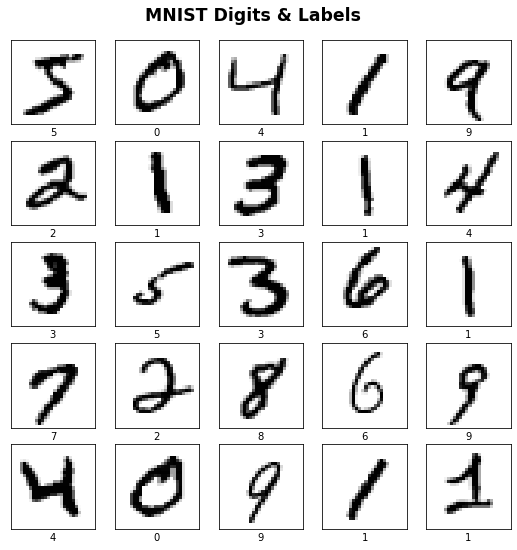

In [5]:
# Displaying first 25 digit images
n_show = 25
plt.figure(figsize=(9, 9))
plt.suptitle('MNIST Digits & Labels', y=0.93, weight='bold', size='xx-large')

for i in range(n_show):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(y_train[i])
    
plt.show()

## Data Pre-processing
---

Reshaping, standardising and shuffling dataset.

In [6]:
# Reshape inputs to (N, N, 1), as there is one colour dimension
X_train = X_train[..., np.newaxis]
X_test  = X_test [..., np.newaxis]

# Rescaling for pixel intensity to be on 0 to 1 scale instead of 0 to 255
X_train = X_train / max_intensity
X_test  = X_test  / max_intensity

# Shuffling
i_x_train = np.random.permutation(nb_train)
i_x_test  = np.random.permutation(nb_test)

X_train = X_train[i_x_train]
y_train = y_train[i_x_train]

X_test  = X_test [i_x_test]
y_test  = y_test [i_x_test]

## Building a Variational Autoencoder
---
Encoder maps each pixel into the latent space distribution.

#### 0 - Input Layer
 - Creates a layer of the correct dimensions for the 28 x 28 images.
 
#### 1 - Convolutional Layers

 - 32, 64 and 128 filter sizes chosen to provide sufficient representational power for MNIST while keeping the model lightweight and efficient.
 - 3 x 3 kernel size chosen to strike a balance between capturing spatial information in the receptive field and being computationally efficient.
 - Strides taken are initally set to 1 (sampling over every pixel) and then increased to 2 (sampling every other pixel) in order to progressively downsample the spatial dimensions of the input (e.g., 28×28 → 14×14 → 7×7) and reduce the size of the feature map to lower computational complexity.
 - EXPAND UPON ReLU activation chosen to avoid vanishing gradients and introduce sparsity. It is also computationally efficient choice for a simpler image.
 - Padding set to "same" to keep images generated later at the correct dimension (28x28).

#### 2 - Flattening
 - Data is flattened into a 1D vector (784-dim or $28^{2}$) to simplify the architecture.

#### 3 - Hidden Fully-Connected Dense Layers
 - Dense layers chosen to reduce the high-dimensional data (flattened feature maps) into a compact, meaningful latent representation and aggregate information globally, ensuring the model can reason about the entire image.
 - 256 nodes chosen as an ideal number in the trade off between having enough complexity to capture patterns and being computationally efficient.
 - ReLU Activation to introduce non-linearity and learn intermediate representations.

 #### 4 - Special Layers
 - Probabilistic representation in the latent space chosen used over a traditional deterministic latent space as VAEs use probabilistic latent spaces to enable smooth interpolations and better generalization.
 - Parameter chosen to allow sampling from a learned Gaussian distribution during training and inference:
    - `z_mean` contains the means of the latent space probability density function (PDF) for a given image
    - `z_log_var` contains the logarithm of the associated variances. Logarithm helps stabilize training and avoids numerical issues with very small values.

#### 5 - Sampling Layer
- The sampling layer bridges the deterministic encoder and stochastic generative process which ensures the model learns a meaningful latent space and enables gradient-based optimization.
 - By incorporating randomness, the sampling layer allows the VAE to generate diverse outputs and interpolate smoothly between data points.
 - The latent vector $z$ is generated from the Gaussian distribution using the reparameterization trick which allows gradients to flow through $\mu$ and $\sigma$, enabling training via stochastic gradient descent.
 - The distribution is represented in the sampling function below:
   
   $ z = \mu + \sigma \cdot \epsilon $

    Where:

    $\mu$ - Mean of the Gaussian distribution - $z_{mean}$\
    $\sigma$ - Standard deviation, derived from the logarithm of the variance - $exp(0.5 \cdot z_{log-var}​)$\
    $\epsilon$ - A random noise vector sampled from a standard normal distribution - ($\epsilon \sim \cal{N} (0, I)$)




#### Variational Auto-Encoder (VAE) Sampling Function

In [7]:
def sampling(args):

  # Unpack arguments
  z_mean, z_log_var = args

  # Get shape of random noise to sample (K = Keras Backend)
  epsilon = K.random_normal(shape = K.shape(z_mean))

  # Return samples from latent space PDF
  return z_mean + K.exp(0.5 * z_log_var) * epsilon

#### Building the Encoder

In [8]:
# Fixed Variables for the Dataset
intermediate_dim = 256
latent_dim = 2
original_shape = (28, 28, 1)
original_dim = np.prod(original_shape) 

In [9]:
# Input layer corresponding to dimensions of the images
encoder_input = Input(shape = original_shape)

# Convolutional layers to extract spatial features
x = Conv2D(32, kernel_size=3, strides=1, activation="relu", padding="same")(encoder_input)
x = Conv2D(64, kernel_size=3, strides=2, activation="relu", padding="same")(x)
x = Conv2D(128, kernel_size=3, strides=2, activation="relu", padding="same")(x)

# Images are flattened into an 784 (28 x 28) pixel long 1D array to simplify the model
x = Flatten()(x)

# Hidden dense layer introduced for further feature extraction
x = Dense(intermediate_dim, activation="relu")(x)
x = Dense(intermediate_dim, activation="relu")(x)

# Special layers for probabilistic representation
z_mean = Dense(latent_dim, name="z_mean")(x)
z_log_var = Dense(latent_dim, name="z_log_var")(x)

# Sampling layer to generate a latent vector z from the PDF
z = sampling([z_mean, z_log_var])

# Building the encoder which combines the layers into a single model
encoder = Model(encoder_input, [z_mean, z_log_var, z], name="encoder")

2025-01-20 17:30:55.931634: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-20 17:30:55.939153: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:196] None of the MLIR optimization passes are enabled (registered 0 passes)


In [10]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 64)   18496       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 7, 7, 128)    73856       conv2d_1[0][0]                   
____________________________________________________________________________________________

## Building the Decoder
---

#### 0 - Input Layer
 - Input layer has the latent space 2 as this is the output shape from the encoder.

#### 1 - Dense Layers
 - Two hidden Dense layers are added with 256 units each, matching the encoder.
 - Dense layers chosen to capture global relationsips between all parts of the latent vector and the reconstructed image.
 - ReLU activation to expand the latent representation and learn high-dimensional features as the dense layers can model complex nonlinear transformations.
 - These layers collectively act to build the blueprint of the image, gradually recovering the high-dimensional data from the compressed form.

#### 2 - Output Layer
 - Dense layer shaped to the original image dimensions.
 - Sigmoid activation function chosen so that output pixel intensities are in the range $[0, 1]$.

#### 3 - Reshape
 - The flattened output is reshaped back into the original image shape (28×28x1) from shape (latent_dim, )

In [11]:
# Input layer corresponding to dimension of the latent space
latent_inputs = Input(shape=(latent_dim,), name="latent_inputs")

# Two dense layers with 256 units and relu activation, the same as the encoder
x = Dense(intermediate_dim, activation="relu")(latent_inputs)
x = Dense(intermediate_dim, activation="relu")(x)

# Output layer: Dense layer with size equal to original image dimensions
decoder_outputs = Dense(original_dim, activation="sigmoid")(x)

# Reshape to match original image shape
decoder_outputs = Reshape(original_shape)(decoder_outputs)

# Defining the decoder model
decoder = Model(latent_inputs, decoder_outputs, name="decoder")

In [12]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
latent_inputs (InputLayer)   [(None, 2)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               768       
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 784)               201488    
_________________________________________________________________
reshape (Reshape)            (None, 28, 28, 1)         0         
Total params: 268,048
Trainable params: 268,048
Non-trainable params: 0
_________________________________________________________________


## Connecting the Encoder and Decoder to Build a VAE Model
---

In [13]:
# Chain together to get VAE
vae_input = encoder.inputs

# Check for case when there is a single tensor
if len(vae_input) == 1:
 vae_input = vae_input[0]
 pass

latent_z = encoder(vae_input)[2]
vae_output = decoder(latent_z)

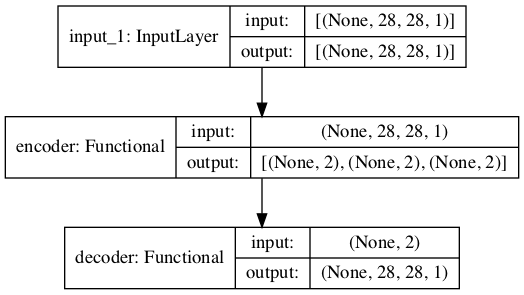

In [14]:
# Building the VAE
vae = Model(inputs = vae_input, outputs = vae_output)

# Plotting the VAE model
plot_model(vae, show_shapes=True)

# Compiling and Training the VAE Model
---
The `compile_vae` methods compiles the VAE model passed as the sole argument. The method also computes:

1. Image reconstruction loss (`reco_loss`) which measures how well the VAE is doing at reconstructing the input images
2. Kullback-Leibler (KL) loss (`kl_loss`) for the latent space PDF which quantifies how continuous the latent representation is

The two losses are then summed (and added as separate metrics for monitoring), and the VAE model is compiled with the Adam optimiser.

In [15]:
def compile_vae(vae):

    # Get the latent PDF mean and log-variance output layers from VAE encoder
    encoder   = vae.get_layer('encoder')
    z_log_var = encoder.get_layer('z_log_var').output
    z_mean    = encoder.get_layer('z_mean').output

    # Define image reconstruction loss
    def reco_loss (y_true, y_pred):
        # Use binary cross-entropy loss
        reco_loss_value = binary_crossentropy(y_true, y_pred) # Averages over axis=-1
        reco_loss_value = K.sum(reco_loss_value, axis=(1,2))
        return reco_loss_value

    # Define Kullback-Leibler loss for latent space PDF with reference to encoder output layers
    def kl_loss (y_true, y_pred):
        kl_loss_value = 0.5 * (K.square(z_mean) + K.exp(z_log_var) - 1. - z_log_var)
        kl_loss_value = K.sum(kl_loss_value, axis=-1)
        return kl_loss_value

    # Define VAE loss
    def vae_loss (y_true, y_pred):
        return reco_loss(y_true, y_pred) + kl_loss(y_true, y_pred)

    vae.compile(optimizer='adam', loss=vae_loss, metrics=[reco_loss, kl_loss])
    return

In [16]:
# Define parameters
nb_epochs  =  50
batch_size = 128

In [17]:
# Calling and compiling the VAE with 2 latent dimensions
compile_vae(vae)

In [18]:
# Training the model with train and validation datasets
vae_history = vae.fit(X_train, X_train, shuffle=True, epochs=nb_epochs, batch_size=batch_size, validation_data=(X_test, X_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - ETA: 0s - loss: 195.5832 - reco_loss: 190.8258 - kl_loss: 4.7575

/opt/anaconda3/envs/daml/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2323: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


60000/60000 [==============================] - 92s 2ms/sample - loss: 195.5832 - reco_loss: 190.8258 - kl_loss: 4.7575 - val_loss: 172.4657 - val_reco_loss: 167.8306 - val_kl_loss: 4.6351
Epoch 2/50
60000/60000 [==============================] - 93s 2ms/sample - loss: 168.1658 - reco_loss: 163.5831 - kl_loss: 4.5826 - val_loss: 165.2837 - val_reco_loss: 160.7080 - val_kl_loss: 4.5757
Epoch 3/50
60000/60000 [==============================] - 95s 2ms/sample - loss: 162.0606 - reco_loss: 157.0420 - kl_loss: 5.0187 - val_loss: 159.5509 - val_reco_loss: 154.2911 - val_kl_loss: 5.2597
Epoch 4/50
60000/60000 [==============================] - 97s 2ms/sample - loss: 157.6791 - reco_loss: 152.3387 - kl_loss: 5.3404 - val_loss: 156.3150 - val_reco_loss: 150.6892 - val_kl_loss: 5.6257
Epoch 5/50
60000/60000 [==============================] - 98s 2ms/sample - loss: 154.9339 - reco_loss: 149.3920 - kl_loss: 5.5419 - val_loss: 154.0401 - val_reco_loss: 148.5217 - val_kl_loss: 5.5184
Epoch 6/50
60000

# Inspecting the Loss Curves
---

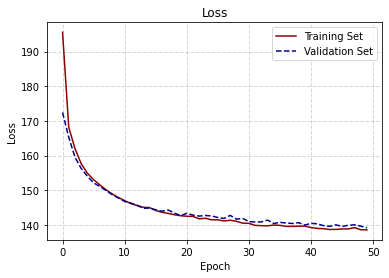

In [24]:
# Getting the loss curves from the training history
loss = vae_history.history['loss']
val_loss = vae_history.history['val_loss']

# Plotting the loss curves
plt.figure(figsize=(6, 4))
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(loss, label='Training Set', color='darkred')
plt.plot(val_loss, label='Validation Set', linestyle='--', color='darkblue')
plt.legend()
plt.grid(linestyle='--', linewidth=1, alpha=0.5)
plt.show()

# Digit Prediction in the 2D Laten Space
---

In [20]:
# Defining colours for the digits
interval = np.linspace(1, 0, nb_classes)
colors = [matplotlib.cm.gist_rainbow(x) for x in interval]

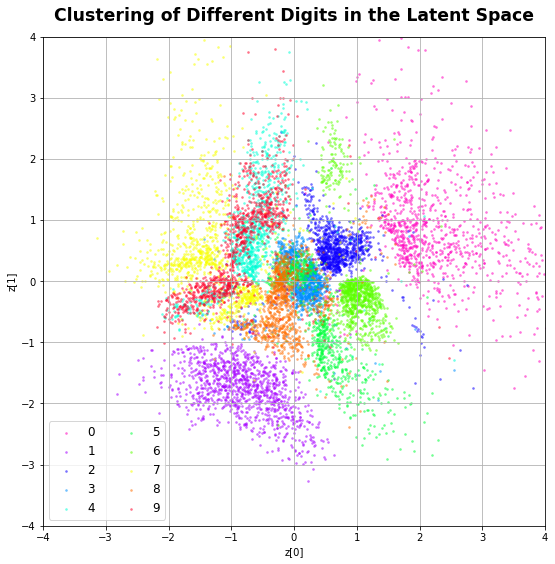

In [21]:
# Predicting the latent space for the test dataset
z_test, _, _ = encoder.predict(X_test, batch_size=batch_size)

# Producing the scatter plot for all of the digits
plt.figure(figsize=(9, 9))
for i in range(0, int(nb_classes)):
    indexes = np.argwhere(y_test==i)
    plt.scatter(z_test[indexes, 0],z_test[indexes, 1], s=3, alpha=.4, color=colors[i], label=i)

plt.title('Clustering of Different Digits in the Latent Space', y=1.02, weight='bold', size='xx-large')
plt.xlabel('z[0]')
plt.ylabel('z[1]')
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.grid()
plt.legend(ncol=2, fontsize='large')
plt.show()

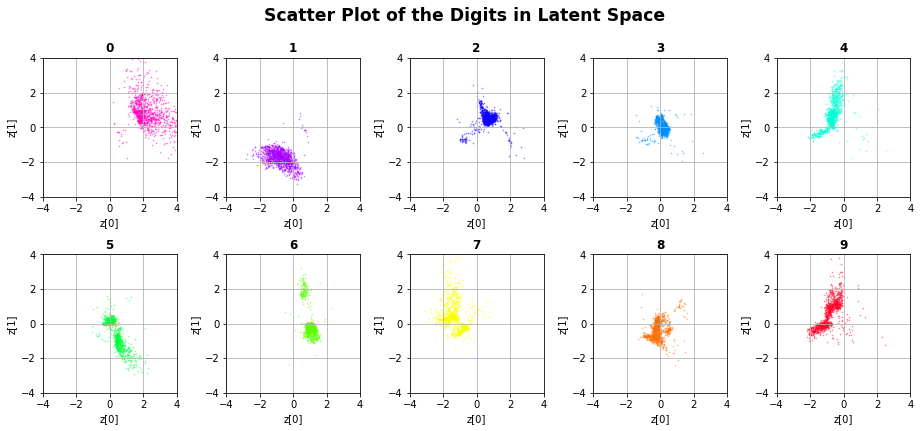

In [22]:
# Producing a scatter plot for each individual digit
fig = plt.figure(figsize=(13,6))
plt.suptitle('Scatter Plot of the Digits in Latent Space', weight='bold', size='xx-large', y=0.99)
rows = 2
columns = 5

# Looping through the classes and adding the scatter plot
for i in range(0, int(nb_classes)):
    fig.add_subplot(rows, columns, i+1)
    fig.tight_layout()
    indexes = np.argwhere(y_test==i)
    plt.scatter(z_test[indexes, 0],z_test[indexes, 1], alpha=.4, s=0.5, color=colors[i])
    plt.title(i, weight='bold')
    plt.xlabel('z[0]')
    plt.ylabel('z[1]')
    plt.xlim(-4, 4)
    plt.ylim(-4, 4)
    plt.grid()

plt.show()

As this is a variational auto-encoder it is a given that some digits will overlap. There is particular overlaps between 5 and 6, 4 and 9, 3 and 8, and finally 3 with 5. This is because these digits have some similar structure and so there is increased probability overlap for cases which could fit into two classes.

# Generating Digit Samples Across the Latent Space of the VAE
---

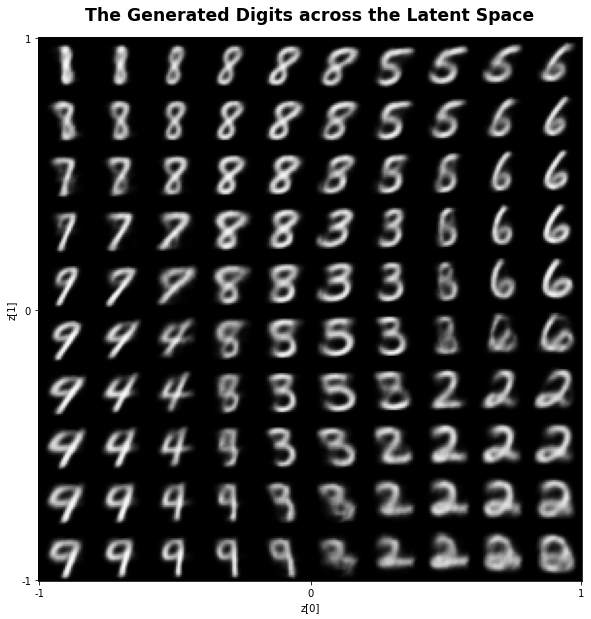

In [23]:
# Setting variables
N = 10
digit_size = 28

# Creating a co-ordinate grid and getting decoder predictions
laten_grid = np.dstack(np.meshgrid(np.linspace(-1, 1, N), np.linspace(-1, 1, N)))
X_decoded = decoder.predict(laten_grid.reshape(N*N, 2))
X_decoded = X_decoded.reshape(N, N, digit_size, digit_size)

# Displaying the grid
plt.figure(figsize=(10, 10))
plt.imshow(np.block(list(map(list, X_decoded))), cmap='gray')
plt.xticks([0, N*digit_size/2, N*digit_size - 1], [-1, 0, 1])
plt.yticks([0, N*digit_size/2, N*digit_size - 1], [1, 0, -1])
plt.title('The Generated Digits across the Latent Space', weight='bold', size='xx-large', y=1.02)
plt.xlabel('z[0]')
plt.ylabel('z[1]')
plt.show()

The figure shows the generation of digits across the latent space. In areas where there is overlap, digits can be seen in an intermediate morphing between stage. Areas where the probability of a certain digit is high have sharp, clearly defined digits (such as the center top 8s).